# MTL, Policies, and Experiments

In this file, we're going to be taking a look at what makes MTL hard (gradient conflicts), and how traditional models rely on static or rigid rule based heuristics to resolve them. We will also take a look at why these methods are often unable to converge to the Pareto front, which provides us the incentive to resort to a trained policy model.

---

## 1. Gradient Interference and Negative Transfer

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity

# Lets create a shared parameter vector (this is our mock "Neural Network")
# Initialized at (0,0)
theta = torch.tensor([0.0, 0.0], requires_grad=True)

print(f"Initial parameters: {theta}")


Initial parameters: tensor([0., 0.], requires_grad=True)


### Simulate Gradient Conflicts
We can define two simple loss functions, lets say:
- Task A wants parameters to move to (2,2)
- Task B wants parameters to move to (-2,-2)

We further multiply Task B's loss by 10.0 to simulate a task that is not only opposing, but also has a larger magnitude.

In [ ]:
def get_task_gradients(theta_input):
    if theta_input.grad is not None:
        theta_input.grad.zero_() # reset the gradients

    # Task A - gradient want to move to (2,2)
    target_A = torch.tensor([2.0, 2.0])
    loss_A = torch.sum((theta_input - target_A) ** 2)
    loss_A.backward(retain_graph=True)

    grad_A = theta_input.grad.clone() #saving the gradient

    
    
    theta_input.grad.zero_() # reset the gradients for Task B again


    # Task B - gradient want to move to (-2,2)
    target_B = torch.tensor([-2.0, -2.0])
    loss_B = torch.sum((theta_input - target_B) ** 2) * 10.0 # magnitude imbalanced!!!
    loss_B.backward(retain_graph=True)

    grad_B = theta_input.grad.clone() # saving the gradient


    return grad_A, grad_B


g_A, g_B = get_task_gradients(theta)

print(f"Task A Gradient: {g_A.numpy()}")
print(f"Task B Gradient: {g_B.numpy()}")



# Cosine similarity between gradients to show they are actually opposing

cos_sim = cosine_similarity(g_A, g_B, dim=0)

print(f"Cosine Similarity between Task A and Task B gradients: {cos_sim}")




Task A Gradient: [-4. -4.]
Task B Gradient: [40. 40.]
Cosine Similarity between Task A and Task B gradients: -0.9999999403953552


The cosine similarity being this close to -1 means the gradients are in the opposing directions!

But lets plot and visually see this as well.

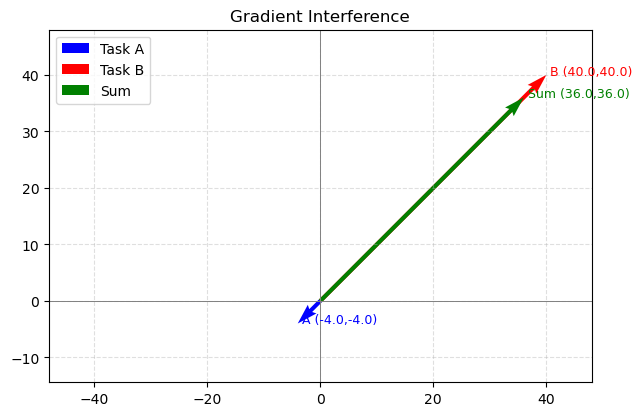

In [41]:
s = g_A + g_B

plt.figure(figsize=(7,7))
plt.axhline(0, color='gray', lw=0.7)
plt.axvline(0, color='gray', lw=0.7)

plt.quiver(0, 0, g_A[0], g_A[1], color='blue', angles='xy', scale_units='xy', scale=1, label='Task A')
plt.quiver(0, 0, g_B[0], g_B[1], color='red', angles='xy', scale_units='xy', scale=1, label='Task B')
plt.quiver(0, 0, s[0], s[1], color='green',angles='xy', scale_units='xy', scale=1, label='Sum')


plt.text(g_A[0], g_A[1], f' A ({g_A[0]},{g_A[1]})', color='blue', fontsize=9)
plt.text(g_B[0], g_B[1], f' B ({g_B[0]},{g_B[1]})', color='red', fontsize=9)
plt.text(s[0], s[1], f' Sum ({s[0]},{s[1]})', color='green',fontsize=9)


lim = max(1.0, np.max(np.abs(np.concatenate([g_A, g_B, s])))) * 1.2
plt.xlim(-lim, lim)
plt.ylim(-0.3*lim, lim)

plt.gca().set_aspect('equal', adjustable='box')

plt.grid(alpha=0.4, linestyle='--')

plt.legend()
plt.title('Gradient Interference')
plt.show()

The Blue arrow is where Task A wants to go. The Red arrow is where Task B wants to go. They are strictly opposed (**Directional Conflict**). However, because Task B has a larger loss scale, the Red arrow is huge. When we simply add them together (Green arrow), the model completely ignores Task A and moves almost exclusively in the direction of Task B (**Magnitude Conflict**)

### Now, lets demonstrate WHY gradient conflicts are such a problem: **Negative Transfer!**
We will create a training loop to show how combining these tasks hurt performance
- Single Task - training only on task A
- Multi Task - training on both Task A and B

Then we compare the final loss of Task A in both scenarios

In [50]:
def train_model(mode, steps=50):
    # reinit model parameters to 0,0
    theta = torch.tensor([0.0, 0.0], requires_grad=True)

    optimizer = torch.optim.SGD([theta], lr=0.1)

    history_loss_A = []

    for i in range(0, steps):
        optimizer.zero_grad()

        target_A = torch.tensor([2.0, 2.0])
        loss_A = torch.sum((theta - target_A) ** 2)

        target_B = torch.tensor([-2.0, -2.0])
        loss_B = torch.sum((theta - target_B) ** 2) * 10.0 # magnitude imbalanced!!!

        if mode == 'MTL':
            final_loss = loss_A + loss_B
        
        elif mode == 'STL':
            final_loss = loss_A


        final_loss.backward()
        optimizer.step()

        history_loss_A.append(loss_A.item())

    return theta.detach().numpy(), history_loss_A


In [53]:
theta_STL, loss_STL = train_model('STL', steps=50)
print(f"Final parameters after STL training: {theta_STL}")
print(f"Loss history on Task A after STL training: {loss_STL}")

theta_MTL, loss_MTL = train_model('MTL', steps=50)
print(f"\n\nFinal parameters after MTL training: {theta_MTL}")
print(f"Loss history on Task A after MTL training: {loss_MTL}")

Final parameters after STL training: [1.9999715 1.9999715]
Loss history on Task A after STL training: [8.0, 5.12000036239624, 3.2767999172210693, 2.097151756286621, 1.3421770334243774, 0.858993411064148, 0.5497556924819946, 0.3518436849117279, 0.2251800149679184, 0.14411520957946777, 0.09223373234272003, 0.05902959033846855, 0.03777896612882614, 0.024178558960556984, 0.015474260784685612, 0.009903526864945889, 0.006338262464851141, 0.004056496545672417, 0.0025961578357964754, 0.001661546528339386, 0.0010633919155225158, 0.0006805690936744213, 0.0004355614073574543, 0.0002787581761367619, 0.00017840522923506796, 0.0001141779066529125, 7.307501073228195e-05, 4.676846947404556e-05, 2.993181988131255e-05, 1.9156956113874912e-05, 1.2260923540452495e-05, 7.846991138649173e-06, 5.022225650463952e-06, 3.2139823815668933e-06, 2.0568520540109603e-06, 1.3165400787329418e-06, 8.426475233136443e-07, 5.392944331106264e-07, 3.451880559168785e-07, 2.2092035578680225e-07, 1.413383188264561e-07, 9.04565

### Look at the last Loss value for each!

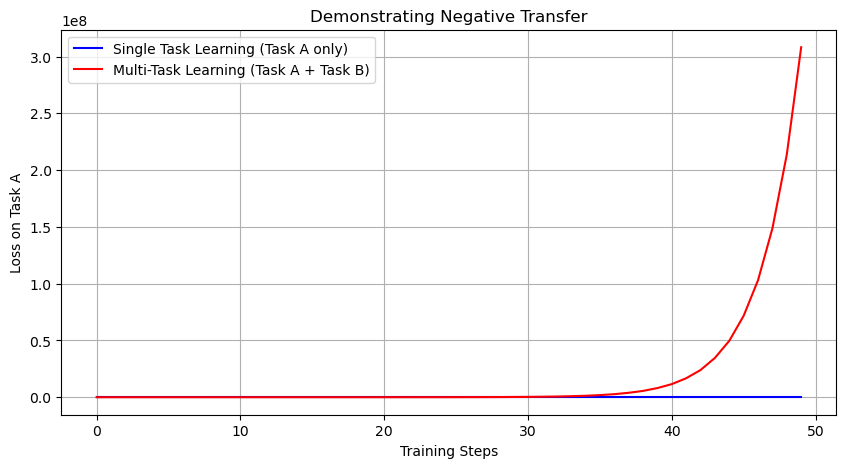

Final Task A Loss (STL): 2.5409292447875487e-09
Final Task A Loss (MTL): 308182784.0
------------------------------
Parameter Position STL: [1.9999715 1.9999715]
Parameter Position MTL: [14890.025 14890.025]


In [57]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(loss_STL, label='Single Task Learning (Task A only)', color='blue')
plt.plot(loss_MTL, label='Multi-Task Learning (Task A + Task B)', color='red')
plt.xlabel('Training Steps')
plt.ylabel('Loss on Task A')
plt.title('Demonstrating Negative Transfer')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Task A Loss (STL): {loss_STL[-1]}")
print(f"Final Task A Loss (MTL): {loss_MTL[-1]:}")
print("-" * 30)
print(f"Parameter Position STL: {theta_STL}")
print(f"Parameter Position MTL: {theta_MTL}")

In the Blue line (STL), we trained only on Task A, and the loss went to zero (perfect convergence).

In the Red line (MTL), we tried to learn both. Because of the Gradient Interference we visualized earlier, the model was pulled away from Task A's goal.

The final loss for Task A is significantly higher in the MTL setting. This gap between the Blue and Red lines is the definition of Negative Transfer. The presence of Task B actively hurt the learning of Task A.

---

## 2. Static Heuristics, Why they Work, and Why they Fail?

## (i) The "Success" Case
We'll implement a minimal PCGrad style rule that says:
```
If two gradients are conflicting (cosine_sim < 0), then remove the projection of the smaller gradient onto the larger one.
```

This will address:
- directional conflict
- magnitude dominance

In [84]:
def project(g_A, g_B):

    proj = (torch.dot(g_A, g_B)/ torch.dot(g_B, g_B)) * g_B

    return proj

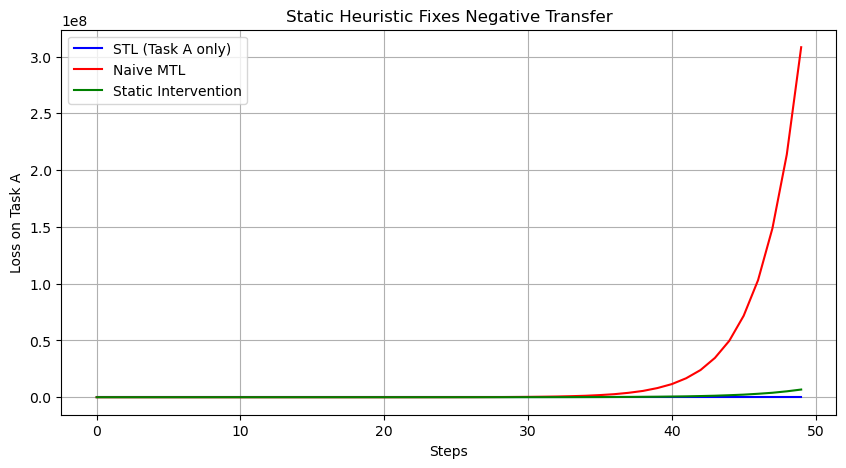

In [ ]:
def static_intervention(g_A, g_B):
    cos_sim = cosine_similarity(g_A, g_B, dim=0)

    if cos_sim < 0:
        # project smaller gradient only
        if torch.norm(g_A) < torch.norm(g_B):
            g_A = g_A - project(g_A, g_B)
        else:
            g_B = g_B - project(g_B, g_A)

    return g_A + g_B




def train_static_intervention(steps=50):
    theta = torch.tensor([0.0, 0.0], requires_grad=True)
    lr = 0.0975

    loss_history_A = []

    for _ in range(steps):
        g_A, g_B = get_task_gradients(theta)

        g_final = static_intervention(g_A, g_B)

        with torch.no_grad():
            theta -= lr * g_final

        target_A = torch.tensor([2.0, 2.0])
        loss_A = torch.sum((theta - target_A) ** 2)
        
        loss_history_A.append(loss_A.item())

    return theta.detach().numpy(), loss_history_A



theta_static, loss_static = train_static_intervention()

plt.figure(figsize=(10,5))
plt.plot(loss_STL, label="STL (Task A only)", color="blue")
plt.plot(loss_MTL, label="Naive MTL", color="red")
plt.plot(loss_static, label="Static Intervention", color="green")

plt.xlabel("Steps")
plt.ylabel("Loss on Task A")
plt.title("Static Heuristic Fixes Negative Transfer")
plt.legend()
plt.grid(True)
plt.show()


AHA!

Now we notice that static intervention/heuristic prevents divergence and its loss is much closer to STL and task A converges again, so we can say that negative transfer is somewhat fixed.

## (ii) The "Failure" Case
The problem with static rules are that:
```
They assume gradient conflict is always bad even when it becomes temporarily useful
```

- Early in the training the conflict between both tasks helps projection
- and Later, they naturally align
- Static rules keeps inferring away
- this results in slower convergence or worse final solution

In [111]:
# We modify task B to change over time!!
# oppose Task A early
# but gradually align with task A later on


def get_task_gradients_time(theta_input, step, switch_step=20):
    if theta_input.grad is not None:
        theta_input.grad.zero_()

    # Task A always wants (2,2)
    target_A = torch.tensor([2.0, 2.0])
    loss_A = torch.sum((theta_input - target_A) ** 2)
    loss_A.backward(retain_graph=True)
    grad_A = theta_input.grad.clone()

    theta_input.grad.zero_()

    # Task B switches behavior-------------------
    if step < switch_step:
        # conflicting early
        target_B = torch.tensor([-2.0, -2.0])
    
    
    else:
        # helpful later
        target_B = torch.tensor([2.0, 2.0])

    loss_B = torch.sum((theta_input - target_B) ** 2) * 5.0
    loss_B.backward(retain_graph=True)
    grad_B = theta_input.grad.clone()

    return grad_A, grad_B


In [ ]:
#def project(g1, g2):
#    return (torch.dot(g1, g2) / torch.dot(g2, g2)) * g2



def static_intervention_bad(g_A, g_B):
    #cos_sim = cosine_similarity(g_A, g_B, dim=0)

    #if cos_sim < 0:
    #    g_A = g_A - project(g_A, g_B)

    return g_A + 0.2 * g_B



This rule **never adapts**

To demonstrate this failure, the heuristic must be rigid even when the task relationships change, which is exactly what learned policies like AIM avoid.

In [ ]:
def train_with_static_failure(mode, steps=50, lr=0.05):
    theta = torch.tensor([0.0, 0.0], requires_grad=True)
    history_A = []

    for step in range(steps):
        gA, gB = get_task_gradients_time(theta, step)

        if mode == "naive":
            g = gA + gB
        
        elif mode == "static_bad":
            g = static_intervention_bad(gA, gB)

        with torch.no_grad():
            theta -= lr * g

        loss_A = torch.sum((theta - torch.tensor([2.0, 2.0])) ** 2)
        history_A.append(loss_A.item())

    return history_A


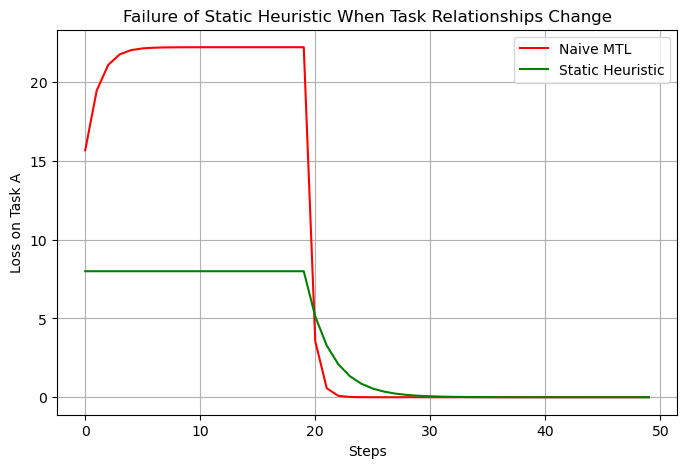

In [122]:
loss_naive = train_with_static_failure("naive")
loss_static = train_with_static_failure("static_bad")

plt.figure(figsize=(8,5))
plt.plot(loss_naive, label="Naive MTL", color="red")
plt.plot(loss_static, label="Static Heuristic", color="green")
plt.xlabel("Steps")
plt.ylabel("Loss on Task A")
plt.title("Failure of Static Heuristic When Task Relationships Change")
plt.legend()
plt.grid(True)
plt.show()


This shows us that in early stages, static heuristics help reduce conflict. After alignment, native MTL accelerates while static heuristics slightly lag and converge slower.


---

# 3. Adaptive Intervention Model (AIM)

This is the core of the paper. To implement Algorithm 1 from the Appendix, we need to treat the optimization process differently than standard PyTorch training.

Instead of ```loss.backward()``` $\rightarrow$ ```optimzer.step()```, AIM requires us to:
- Compute gradients for each task separately.
- Manipulate them using a second neural network (The **Policy**)
- Calculate a specific loss for that Policy using a **Guidance Set**
- Update both the Main model and the Policy

## (i) Simple MTL Model 
This is going to be our main neural network (Backbone + Heads)

## (ii) AIM Policy Model
This will contain the policy network ($\tau$, $\Phi$) and the intervention logic

## (iii) Training AIM 
And now finally, we will implement the algorithm found in Appendix A.1 (the pseudocode for how AIM trains).

Were going to create 100 samples in a simple dataset using ```sklearn.datasets.make_regression``` because itll allow us to create a perfect multi-task dataset with four tasks (target) from same input features. It requires no downloading, no processing, and we can contrrol the noise.

In [1]:
import torch.optim as optim
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from simple_mtl_model import SimpleMTLModel
from aim_policy import AIMPolicy

### Lets create the simplest possible MTL Datset

3 Regression Tasks from the same 20 input features

In [19]:
X, y = make_regression(n_samples=200, n_features=20, n_targets=4, noise=0.1, random_state=42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [20]:
# 80-20 split where 80% is primary training, 10% is guidance, and other 10% is test

X_primary, X_guide, y_primary, y_guide = train_test_split(X, y, test_size=0.2, random_state=42)

[OPTIONAL]

This was generating data points that were very large (courtesy of make_regression func that generates target values 'y' that are linear combinations of inputs). If our input has 20 features the target values can easily range from -200 to +200. 

Now apply MSE on that (for example if true target is 150 and model predicts 0, we can get $(150-0)^2 = 22,500$ 



To fix this, Im simply normalizing the targets for now so they have a mean of 0 and standard dev of 1.

In [21]:
# Optional: NORMALIZE TARGETS (Fixes the large loss values)
# Calculate mean and std from the training set only
y_mean = y_primary.mean(dim=0)
y_std = y_primary.std(dim=0)

# Standardize both Primary and Guidance sets
y_primary = (y_primary - y_mean) / y_std
y_guide = (y_guide - y_mean) / y_std

print(f"New Target Mean: {y_primary.mean():.4f}")
print(f"New Target Std:  {y_primary.std():.4f}")

New Target Mean: 0.0000
New Target Std:  0.9976


### Model Setup

In [22]:
input_dim = 20
hidden_dim = 64
num_tasks =4


main_model = SimpleMTLModel(input_dim, hidden_dim, num_tasks) # our main prediction model 

policy = AIMPolicy(num_tasks, policy_type='matrix') # aim policy model

In [23]:
# Optimizers

optimizer_model = optim.Adam(main_model.parameters(), lr=0.001)
optimizer_policy = optim.Adam(policy.parameters(), lr=0.01)

# Hyperparams from paper
lambda_guide = 1.0
lambda_mag = 0.01
lambda_prog = 0.1

losses_log = []

### Training

Starting Training Loop...
Epoch 0: Avg Loss 0.9871 | Policy Loss 2.9677
Epoch 10: Avg Loss 0.8832 | Policy Loss 2.7431
Epoch 20: Avg Loss 0.7739 | Policy Loss 2.4978
Epoch 30: Avg Loss 0.6476 | Policy Loss 2.1755
Epoch 40: Avg Loss 0.5074 | Policy Loss 1.7911
Epoch 50: Avg Loss 0.3678 | Policy Loss 1.3866
Epoch 60: Avg Loss 0.2452 | Policy Loss 1.0113
Epoch 70: Avg Loss 0.1507 | Policy Loss 0.7188
Epoch 80: Avg Loss 0.0871 | Policy Loss 0.5087
Epoch 90: Avg Loss 0.0500 | Policy Loss 0.3697
Training Complete----------------------------------------------


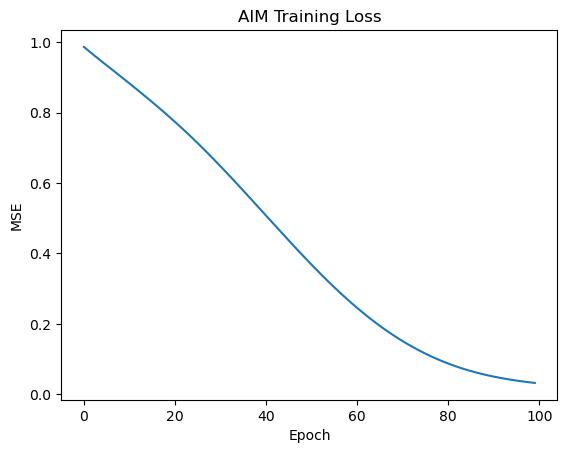

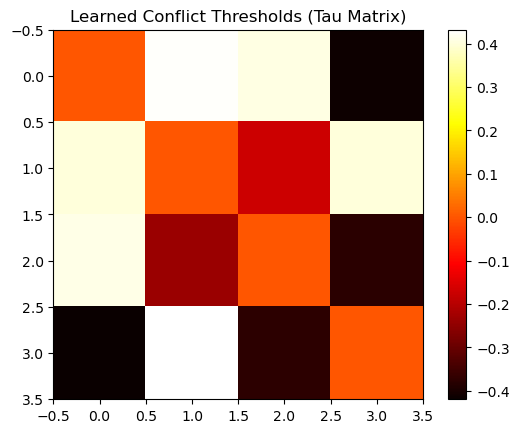

In [24]:
print("Starting Training Loop...")

for epoch in range(100):
    
    # STEP 1: Compute the raw gradients on primary data------------------------------------
    optimizer_model.zero_grad()

    # Forward pass
    preds = main_model(X_primary)

    # Compute loss per task, and gradients per task
    task_losses = []
    raw_gradients = []

    for i in range(num_tasks):
        # MSE Loss for each task
        loss = torch.nn.functional.mse_loss(preds[i].squeeze(), y_primary[:, i])
        task_losses.append(loss)

        # Compute gradient for this task specifically
        # create_graph=True is needed if we were doing second-order meta-learning
        # But AIM paper says: "Stop gradient applied to g_i for policy input"
        # So we use autograd.grad to get the vector, but we DETACH it for the policy input
        grads = torch.autograd.grad(loss, main_model.backbone.parameters(), retain_graph=True)


        # Flatten grads into a single vector for our policy to digest
        flat_grad = torch.cat([g.view(-1) for g in grads])
        
        # IMPORTANT: Detach! The policy sees these as fixed inputs.
        raw_gradients.append(flat_grad.detach())


    # STEP 2: Differentiable Gradient Intervention---------------------------------------
    # policy model takes raw gradients and returns clean update vector
    # This vector DOES have gradients attached to the Policy parameters (tau)
    g_intervened = policy.get_intervened_gradient(raw_gradients)



    # STEP 3: Compute policy loss on Guidance Data-----------------------------------------
    optimizer_policy.zero_grad()
    
    # 3a: Guidance Loss (Generalization)
    # Forward pass on held-out guidance data
    preds_guide = main_model(X_guide)
    loss_guide = 0
    
    for i in range(num_tasks):
        loss_guide += torch.nn.functional.mse_loss(preds_guide[i].squeeze(), y_guide[:, i])


    # 3b: Magnitude Preservation 
    # Penalty = (||g_intervened|| - sum(||g_i||))^2 

    sum_raw_norms = sum([torch.norm(g) for g in raw_gradients])
    loss_mag = (torch.norm(g_intervened) - sum_raw_norms)**2


    # 3c. Progress Penalty
    # Reward interventions that help tasks with high current loss
    # alpha_i = L_i / sum(L_j)

    total_loss_val = sum([l.item() for l in task_losses])
    loss_progress = 0
    
    for i in range(num_tasks):
        alpha_i = task_losses[i].item() / (total_loss_val + 1e-8)
        
        # Projected progress: dot product of final update and task desire
        # We assume g_intervened correlates with progress
        proj_progress = torch.dot(g_intervened, raw_gradients[i]) 
        loss_progress -= (alpha_i * proj_progress)

    
    
    # Total Policy Loss
    L_policy = (lambda_guide * loss_guide) + (lambda_mag * loss_mag) + (lambda_prog * loss_progress)
    
    # Update Policy
    L_policy.backward()
    optimizer_policy.step()




    # STEP 4: Update Main Model
    # We now have g_intervened. We need to put it back into models parameters
    # This is a bit manual in PyTorch.
    optimizer_model.zero_grad()


    # Helper to slice the flat g_intervened back into shapes
    pointer = 0
    for param in main_model.backbone.parameters():
        num_param = param.numel()
        # Slice the chunk corresponding to this parameter
        grad_chunk = g_intervened[pointer : pointer + num_param]
        # Reshape it
        grad_chunk = grad_chunk.view(param.shape)
        
        # Manually set the gradient
        if param.grad is None:
            param.grad = grad_chunk.detach() # Detach to stop graph history
        else:
            param.grad.copy_(grad_chunk.detach())
            
        pointer += num_param

    
    # Now standard Adam step uses our custom gradients
    optimizer_model.step()

    # Logging
    avg_loss = sum(task_losses).item() / num_tasks
    losses_log.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Avg Loss {avg_loss:.4f} | Policy Loss {L_policy.item():.4f}")

print("Training Complete----------------------------------------------")




# Visualization
plt.plot(losses_log)
plt.title("AIM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

# Visualize the Learned Policy Matrix (Tau)
plt.imshow(policy.tau.detach().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Learned Conflict Thresholds (Tau Matrix)")
plt.show()

## What am I looking at?

### (i) Main Model and Policy Model Loss
The training loss starts off at roughly 1.0 (because we standardized our target values) and with a smooth curve converges around 0.05. This smooth curve tells us that AIMs intervention did not destabalize the training which is a common/obvious risk when using gradient resolution methods.

The policy models loss also decreases. This trells us that policy is successfully optimizing its objective. It is finding a balance between minimizing the validation error (Guidance Loss) and satisfying the constraints we added (Magnitude Preservation and Progress Penalties).

### (ii) Learned Conflict Relationships (Tau Matrix) 
This heatmap represents the **Learned Conflict Thresholds** ($\tau_{i,j}$) for our 4 tasks. The lower the value of $\tau$ the more we can interpret that "these tasks are acctually quite compatible and dont need much intervention".

- Diagonal Values (Orange/0.0)
    - Diagonal values are just comparing the tasks with themselves. We already skip this in our code and hence these values stay at 0.0 and are never updated.

- Darker Squares (Negative $\tau$)
    - If we look at [3, 0] value is roughly -0.4
    - A negative threshold means the policy allows gradients to pass even if they are somewhat misaligned (low cosine similarity). The policy has learned that these specific tasks (e.g., Task 3 and Task 0) likely help each other, or at least dont cause enough damage to warrant a strong intervention.

- Lighter Squares (Positive $\tau$)
    - If we look at [0, 2], the value is roughly 0.4
    - A positive threshold means the policy is "paranoid." It requires a high degree of alignment (high cosine similarity) before it lets gradients pass untouched. If the alignment is below this high bar, the projection weight $w$ becomes large, and AIM actively removes the conflicting components. The policy has identified that Task 0 and Task 2 are prone to destructive interference.


The variety of colors in the heatmap proves that AIM is working. Instead of a static rule (like PCGrad, which treats everyone the same), AIM has learned a custom strategy: it is strict with Task pair (0,2) but relaxed with Task pair (3,0).

---

# 4. Experiments

## (i) The Sabotage Experiment
In real-world drug discovery, some datasets are just "junk" (noisy, unreliable, or completely uncorrelated with the input features). A standard Multi-Task model will blindly try to learn this junk, wasting capacity and confusing the shared backbone, which hurts the valid tasks.


We are going to take our valid dataset but we intentionally corrupt Task 0. We replace its target values (```y[:, 0]```) with pure Gaussian noise that has no relationship to the input X.
- Task 0: Random Noise (The Saboteur)
- Task 1, 2, 3: Valid Regression Tasks

In [30]:
# 1. SETUP DATA WITH A SABOTEUR ----------------

X, y = make_regression(n_samples=200, n_features=20, n_targets=4, noise=0.1, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_primary, X_guide, y_primary, y_guide = train_test_split(X, y, test_size=0.2, random_state=42)


# Sabotaging
print("Injecting Noise into Task 0...")
# Overwrite Task 0 targets with random Gaussian noise
# We scale it to have roughly the same magnitude as the real data initially
y_primary[:, 0] = torch.randn_like(y_primary[:, 0]) * y_primary[:, 0].std()
y_guide[:, 0] = torch.randn_like(y_guide[:, 0]) * y_guide[:, 0].std()

# We normalize AFTER sabotage so the noise has Mean=0, Std=1 just like the real tasks
y_mean = y_primary.mean(dim=0)
y_std = y_primary.std(dim=0)


y_primary = (y_primary - y_mean) / y_std
y_guide = (y_guide - y_mean) / y_std

print("Data Setup Complete. Task 0 is now pure noise.")

Injecting Noise into Task 0...
Data Setup Complete. Task 0 is now pure noise.


In [33]:
# Same training loop as before (copy pasted from above)

input_dim = 20
hidden_dim = 64
num_tasks = 4

model = SimpleMTLModel(input_dim, hidden_dim, num_tasks)
policy = AIMPolicy(num_tasks, policy_type='matrix') 

optimizer_model = optim.Adam(model.parameters(), lr=0.001)
optimizer_policy = optim.Adam(policy.parameters(), lr=0.01)

lambda_g = 1.0
lambda_m = 0.01
lambda_p = 0.1 

losses_log = []

task_losses_log = {
    0:[], 
    1:[], 
    2:[], 
    3:[]
} # track individual tasks

for epoch in range(100):
    
    # 1. Gradients
    optimizer_model.zero_grad()
    preds = model(X_primary)
    
    task_losses = []
    raw_gradients = []
    
    for i in range(num_tasks):
        loss_i = torch.nn.functional.mse_loss(preds[i].squeeze(), y_primary[:, i])
        task_losses.append(loss_i)
        
        # Log individual task loss
        task_losses_log[i].append(loss_i.item())
        
        grads = torch.autograd.grad(loss_i, model.backbone.parameters(), retain_graph=True)
        flat_grad = torch.cat([g.view(-1) for g in grads])
        raw_gradients.append(flat_grad.detach())

    # 2. Intervention
    g_intervened = policy.get_intervened_gradient(raw_gradients)
    
    # 3. Policy Update
    optimizer_policy.zero_grad()
    
    # Guidance
    preds_guide = model(X_guide)
    loss_guide = 0
    for i in range(num_tasks):
        loss_guide += torch.nn.functional.mse_loss(preds_guide[i].squeeze(), y_guide[:, i])
    
    # Magnitude
    sum_raw_norms = sum([torch.norm(g) for g in raw_gradients])
    loss_mag = (torch.norm(g_intervened) - sum_raw_norms)**2
    
    # Progress
    total_loss_val = sum([l.item() for l in task_losses])
    loss_progress = 0
    for i in range(num_tasks):
        alpha_i = task_losses[i].item() / (total_loss_val + 1e-8)
        proj_progress = torch.dot(g_intervened, raw_gradients[i]) 
        loss_progress -= (alpha_i * proj_progress)
        
    L_policy = (lambda_g * loss_guide) + (lambda_m * loss_mag) + (lambda_p * loss_progress)
    L_policy.backward()
    optimizer_policy.step()
    
    # 4. Model Update
    optimizer_model.zero_grad()
    pointer = 0
    for param in model.backbone.parameters():
        num_param = param.numel()
        grad_chunk = g_intervened[pointer : pointer + num_param]
        grad_chunk = grad_chunk.view(param.shape)
        if param.grad is None:
            param.grad = grad_chunk.detach()
        else:
            param.grad.copy_(grad_chunk.detach())
        pointer += num_param
    optimizer_model.step()
    
    if epoch % 20 == 0:
        avg_loss = sum(task_losses).item() / num_tasks
        print(f"Epoch {epoch}: Avg Loss {avg_loss:.4f}")


Epoch 0: Avg Loss 1.0291
Epoch 20: Avg Loss 0.8821
Epoch 40: Avg Loss 0.6802
Epoch 60: Avg Loss 0.4214
Epoch 80: Avg Loss 0.2457


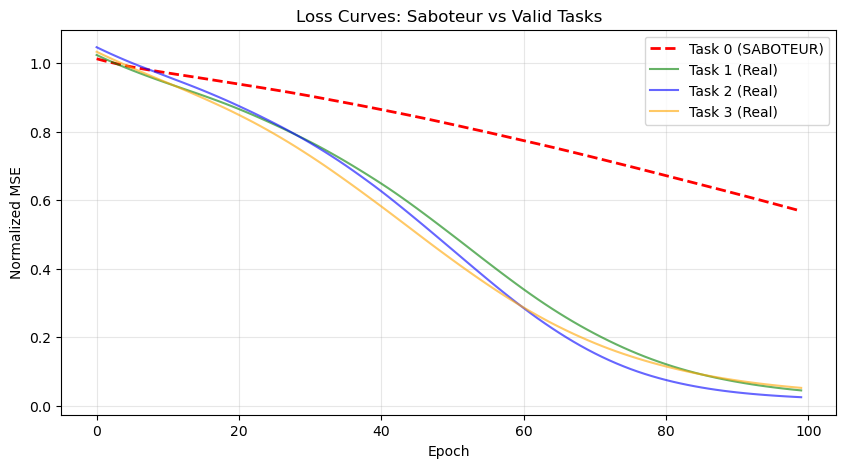

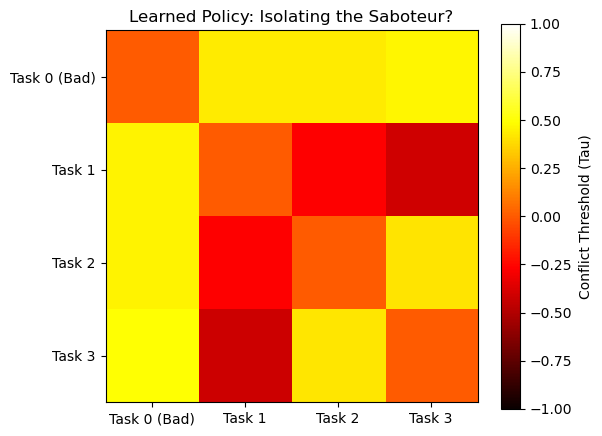

In [ ]:
# Plot Loss Curves (Saboteur vs Real Tasks)
plt.figure(figsize=(10, 5))
plt.plot(task_losses_log[0], label='Task 0 (SABOTEUR)', linestyle='--', color='red', linewidth=2)
plt.plot(task_losses_log[1], label='Task 1 (Real)', color='green', alpha=0.6)
plt.plot(task_losses_log[2], label='Task 2 (Real)', color='blue', alpha=0.6)
plt.plot(task_losses_log[3], label='Task 3 (Real)', color='orange', alpha=0.6)
plt.title("Loss Curves: Saboteur vs Valid Tasks")
plt.xlabel("Epoch")
plt.ylabel("Normalized MSE")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#  Interpretability Heatmap
plt.figure(figsize=(6, 5))
plt.imshow(policy.tau.detach().numpy(), cmap='hot', interpolation='nearest', vmin=-1.0, vmax=1.0)
plt.colorbar(label='Conflict Threshold (Tau)')
plt.xticks(range(4), ['Task 0 (Bad)', 'Task 1', 'Task 2', 'Task 3'])
plt.yticks(range(4), ['Task 0 (Bad)', 'Task 1', 'Task 2', 'Task 3'])
plt.title("Learned Policy: Isolating the Saboteur?")
plt.show()

## What am I looking at?
- Task 0 remains at a higer loss. This is expected since task 0 is pure Gaussian noise, it has no correlation with the input features (no model can learn it perfectly AKA irreducible error) whereas task 1, 2, 3 converge successfully.

- Understand this: 
    - In standard Multi-Task Learning, a noisy task with large, random gradients often destroys the shared backbone, causing "Negative Transfer" that prevents the valid tasks from learning.
    - **The fact that the solid lines converged smoothly proves that AIM successfully "quarantined" the noise. It prevented the random gradients of Task 0 from corrupting the weights needed by Tasks 1, 2, 3.**

- The heatmap shows up how AIM achieved this "quarantine"
    - Row 0 and col 0 indicate a high positive tau threshold. This means the policy is extremely strict and tells the optimizer "Unless task 0's gradient perfectly aligns with others (which it can never since its random) project is out completely".

- The policy effectively learns to cut out the sabotages connection between task 0 and rest of the network


### Basically,
This experiment demonstrates ```AIM's interpretability```. Without being told which task was noise, the learned policy matrix automatically identified Task 0 as the outlier and visualized it for us via the high conflict thresholds.

## (ii) Wait, I thought this course as called "ML4**NLP**"

Modern NLP is almost entirely founded on Textual Classification. Imagine we are building an email filter. We want our model to do a bunch of different things simultaneously, but mainly:
- Task A (Sentiment): Is the email Positive or Negative? (e.g., ```"I love this service"``` vs. ```"I hate this service"```).
- Task B (Spam): Is the email Spam or Real? (e.g., ```"Buy now for free!"``` vs. ```"Meeting at 5pm"```).



### Can these two tasks fight over each other?
We know that standard MTL training is "dumb". When training for Sentiment, the model will look at all words, including ```"Buy"``` and ```"Free."``` It might accidentally learn that ```"Free"``` is a positive word (because everyone likes free stuff), even though in this context it's actually a Spam indicator.

This creates Interference: The "Spam" features confuse the "Sentiment" task and vice-versa.

### So what is AIM supposed to do?
AIM's Job is that it should learn to separate these concerns. The heatmap should show that when optimizing Task A, gradients coming from the "Spam words" are ignored or dampened.

### Setup
Instead of using real raw text, we simulate a simple input vector of 20 "words" (features).
- Words 0-9 will be **sentiment** words. Representations of ```Good```, ```Bad```, ```Happy```, ```Sad```
    - These are important for Task A, but useless for Task B
- Words 10-19 will **spam** words. Representations of ```Buy```, ```Free```, ```Click```, ```Offer```
    - These matter for Task B, but are useless for Task A

In [68]:
# 1. SETUP "MIXED SIGNALS" NLP DATA -----------------------------------
# We simulate 200 emails, each with 20 words (features)
# Features 0-9: Sentiment Words (Good, Bad, Happy...)
# Features 10-19: Spam Words (Free, Buy, Click...)

n_samples = 200
n_features = 20


np.random.seed(42)
X_nlp = np.random.randn(n_samples, n_features)



In [69]:
# Define True Weights (The "Grammar" of our synthetic language)

w_sentiment = np.random.randn(n_features)
w_sentiment[10:] = 0  # Sentiment ONLY cares about words 0-9


w_spam = np.random.randn(n_features)
w_spam[:10] = 0       # Spam ONLY cares about words 10-19

In [70]:
#print(w_sentiment)
#print(w_spam)

In [71]:
# Generate Targets based on these distinct features
y_sentiment = X_nlp @ w_sentiment + np.random.normal(0, 0.1, n_samples)
y_spam = X_nlp @ w_spam + np.random.normal(0, 0.1, n_samples)

# Stack them: Task 0 = Sentiment, Task 1 = Spam
y_nlp = np.stack([y_sentiment, y_spam], axis=1)

In [72]:
# Convert to PyTorch & Normalize
X_nlp = torch.tensor(X_nlp, dtype=torch.float32)
y_nlp = torch.tensor(y_nlp, dtype=torch.float32)

# Normalize Targets (Crucial for AIM stability)
y_mean = y_nlp.mean(dim=0)
y_std = y_nlp.std(dim=0)
y_nlp = (y_nlp - y_mean) / y_std

#  Split
X_train, X_guide, y_train, y_guide = train_test_split(X_nlp, y_nlp, test_size=0.2, random_state=42)


In [73]:
# 2. SETUP MODELS ----------------------------------
# Same architecture as before

model_nlp = SimpleMTLModel(input_dim=20, hidden_dim=64, num_tasks=2)
policy_nlp = AIMPolicy(num_tasks=2, policy_type='matrix')


opt_model = optim.Adam(model_nlp.parameters(), lr=0.005)
opt_policy = optim.Adam(policy_nlp.parameters(), lr=0.01)




In [74]:
import torch.nn.functional as F

# 3. TRAINING LOOP -------------------------------------
print("\nStarting NLP Training...")
loss_history_sent = []
loss_history_spam = []

for epoch in range(100):
    # 1: Gradients ---
    opt_model.zero_grad()
    preds = model_nlp(X_train)
    
    raw_grads = []
    task_losses = []
    
    # Task 0: Sentiment
    loss_sent = torch.nn.functional.mse_loss(preds[0].squeeze(), y_train[:, 0])
    task_losses.append(loss_sent)
    loss_history_sent.append(loss_sent.item())
    
    g_sent = torch.autograd.grad(loss_sent, model_nlp.backbone.parameters(), retain_graph=True)
    raw_grads.append(torch.cat([g.view(-1) for g in g_sent]).detach())
    
    # Task 1: Spam
    loss_spam = torch.nn.functional.mse_loss(preds[1].squeeze(), y_train[:, 1])
    task_losses.append(loss_spam)
    loss_history_spam.append(loss_spam.item())
    
    g_spam = torch.autograd.grad(loss_spam, model_nlp.backbone.parameters(), retain_graph=True)
    raw_grads.append(torch.cat([g.view(-1) for g in g_spam]).detach())
    
    # 2: AIM Intervention ---
    g_final = policy_nlp.get_intervened_gradient(raw_grads)
    
    # 3: Policy Update (Simplified for brevity) ---
    opt_policy.zero_grad()
    # Guidance Loss only
    p_guide = model_nlp(X_guide)
    l_guide = F.mse_loss(p_guide[0].squeeze(), y_guide[:,0]) + F.mse_loss(p_guide[1].squeeze(), y_guide[:,1])
    
    # Magnitude Penalty
    l_mag = (torch.norm(g_final) - sum([torch.norm(g) for g in raw_grads]))**2
    
    L_pol = l_guide + 0.01 * l_mag
    L_pol.backward()
    opt_policy.step()
    
    # 4: Model Update ---
    opt_model.zero_grad()
    pointer = 0
    for param in model_nlp.backbone.parameters():
        num = param.numel()
        param.grad = g_final[pointer:pointer+num].view(param.shape).detach()
        pointer += num
    opt_model.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Sent Loss {loss_sent:.4f} | Spam Loss {loss_spam:.4f}")

print("Training Complete.")


Starting NLP Training...
Epoch 0: Sent Loss 0.9550 | Spam Loss 1.0021
Epoch 20: Sent Loss 0.0694 | Spam Loss 0.0645
Epoch 40: Sent Loss 0.0104 | Spam Loss 0.0071
Epoch 60: Sent Loss 0.0019 | Spam Loss 0.0015
Epoch 80: Sent Loss 0.0006 | Spam Loss 0.0004
Training Complete.


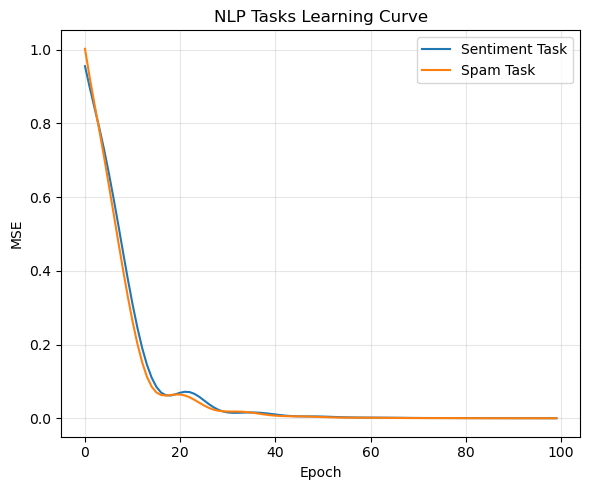

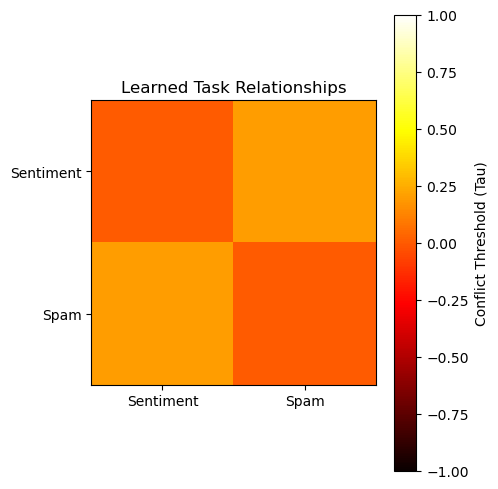

In [75]:
# 4. VISUALIZATION ----------------------------------


# Loss Curves --------
plt.figure(figsize=(6, 5))

plt.plot(loss_history_sent, label='Sentiment Task')
plt.plot(loss_history_spam, label='Spam Task')

plt.title('NLP Tasks Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Policy Matrix --------
plt.figure(figsize=(5, 5))

im = plt.imshow(
    policy_nlp.tau.detach().numpy(),
    cmap='hot',
    vmin=-1,
    vmax=1
)

plt.title('Learned Task Relationships')
plt.xticks([0, 1], ['Sentiment', 'Spam'])
plt.yticks([0, 1], ['Sentiment', 'Spam'])

plt.colorbar(im, label='Conflict Threshold (Tau)')

plt.tight_layout()
plt.show()


## What am I looking at?
- Both tasks converged to near-zero error, proving the model learned to separate Sentiment from Spam. 
- The small "bump" around Epoch 20 likely marks the moment AIM intervened to stop the model from confusing the two tasks (e.g., using "Spam" words to predict "Sentiment"), correcting the trajectory.
    - This likely represents the moment of Correction. Early in training, the model might have tried to use "Spam words" (like 'Free') to predict "Sentiment." This caused confusion (interference). Around Epoch 20, the Policy likely adjusted the gradients to stop this cross-contamination, allowing the model to finally converge to the correct solution.

- The yellow and orange squares indicate a positive tau threshold.
- This represents a "Strict" Policy. AIM detected that these tasks use different features (different words) and effectively enforced a "Stay in Your Lane" rule. It allowed both tasks to learn simultaneously without overwriting each other's specific weights.

### Basically, 
In this experiemnt we forced one model to learn two completely different concepts: Sentiment and Spam detection. The Loss Curve shows that despite the potential for confusion, the model mastered both tasks. The Heatmap tell us why -> AIM learned a Positive Threshold (Yellow squares). This essentially acts as a traffic cop, telling the Sentiment task to 'stay in its lane' (features 0-9) and the Spam task to 'stay in its lane' (features 10-19), preventing them from interfering with each other